## Modelling

In [149]:
%matplotlib inline
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")

## 1.- SIR models

We will now **try** to replicate the SIR model from MUNQU (Polytechnic University of Valencia), held at https://covid19.webs.upv.es/.

\begin{align}
S(t+1) &= S(t) - \beta_t S(t) \frac{I(t)}{n_T}\\
I(t+1) &= I(t) + \beta_t S(t) \frac{I(t)}{n_T} - \gamma I(t)\\
R(t+1) &=  \gamma I(t)\\
\end{align}

In [20]:
def read_covid_csv(data_url: str) -> pd.DataFrame:
    df = pd.read_csv(data_url, index_col=0).set_index("CCAA").transpose()
    dates = pd.to_datetime(df.index, format="%d/%m/%Y")
    df.index = dates
    return df.sort_index()

In [21]:
url_prefix = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019"
cases_url = f"{url_prefix}/ccaa_covid19_casos.csv"
recovered_url = f"{url_prefix}/ccaa_covid19_altas.csv"
deceased_url = f"{url_prefix}/ccaa_covid19_fallecidos.csv"

dfs = {}
dfs["cases"] = read_covid_csv(cases_url)
dfs["recovered"] = read_covid_csv(recovered_url)
dfs["deceased"] = read_covid_csv(deceased_url)

We will reproduce the model in an iterative manner, where each version of the model will incorporate better improvements

In [25]:
# Spanish population, most recent figure
# source https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176951&menu=ultiDatos&idp=1254735572981
nT = 47_100_396
# series of infected subjects
idx = dfs["cases"]["Total"].index
real_I = dfs["cases"]["Total"].values
real_R = (dfs["recovered"]["Total"] + dfs["deceased"]["Total"]).reindex(idx).fillna(0).values

### 1.1.- Model version 1.0

Hypotheses (mostly wrong):
- Unique value for beta. This has the drawback that considers the confinement measures will have no effect.
- Infected are fitted to the positives, which are not the "real infected".
- Recovered are "real recovered" + deceased

In [84]:
def sir_model_v1(params: List[float]):
    # yeah, global variables... :)
    global real_I, realR, nT

    # model params
    beta, gamma = params[0], params[1]

    # predicted S, I, R
    S = np.zeros(real_I.shape)
    I = np.zeros(real_I.shape)
    R = np.zeros(real_I.shape)
    
    # initial conditions
    S[0] = nT - real_I[0]
    I[0] = real_I[0]
    
    for i in range(1, len(S)):
        S[i] = S[i - 1] - beta * S[i - 1] * I[i - 1] / nT
        I[i] = I[i - 1] + beta * S[i - 1] * I[i - 1] / nT - gamma*I[i - 1]
        R[i] = R[i - 1] + gamma*I[i - 1]
        
    sse_error_i = (I - real_I)**2
    sse_error_r = (R - real_R)**2
    
    return sum(sse_error_i) + sum(sse_error_r)

In [86]:
output = minimize(sir_model_v1, [0.01, 1], method='Nelder-Mead')

In [87]:
beta, gamma = output.x
beta, gamma

(0.42198525012796523, 0.054770828765383056)

We print the obtained SSE

In [184]:
sir_model_v1([beta, gamma])

232585517.61120382

Simulation

In [144]:
def simulate_sir_model_v1(beta, gamma, N: int):
    # predicted S, I, R
    S = np.zeros((N, ))
    I = np.zeros((N, ))
    R = np.zeros((N, ))

    # initial conditions
    S[0] = nT - real_I[0]
    I[0] = real_I[0]

    for i in range(1, N):
        S[i] = S[i - 1] - beta * S[i - 1] * I[i - 1] / nT
        I[i] = I[i - 1] + beta * S[i - 1] * I[i - 1] / nT - gamma*I[i - 1]
        R[i] = R[i - 1] + gamma*I[i - 1]
    return S, I, R

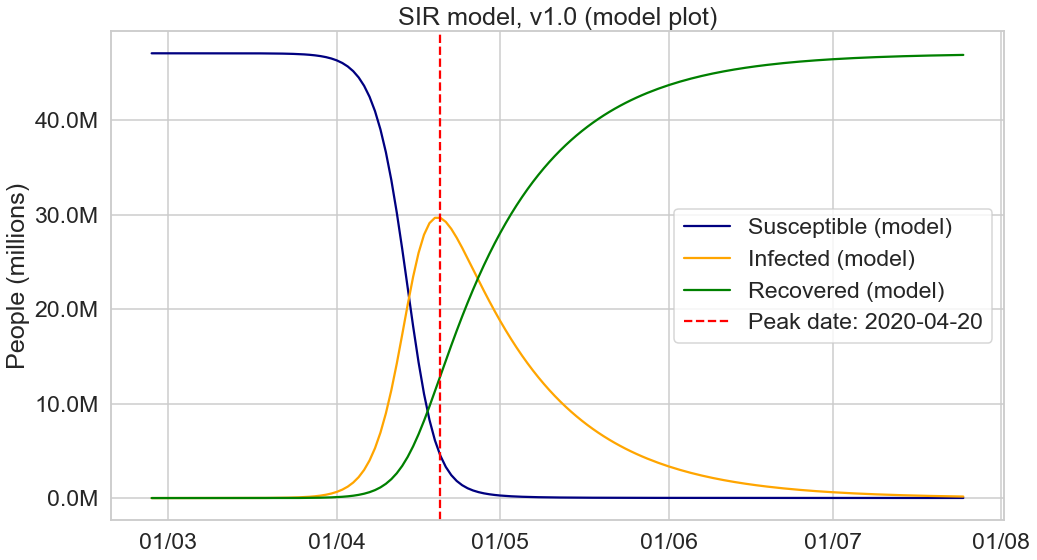

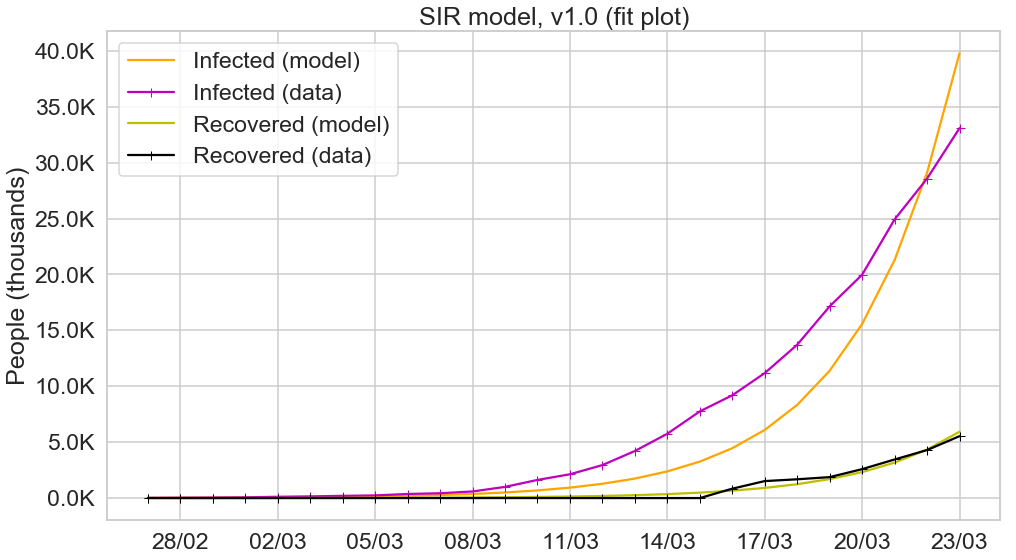

In [183]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_model(S, I, R, x0, N=150):
    styles = ['navy','orange','g']

    # (1) plot for model
    fig, ax = plt.subplots(figsize=(16, 9))
    dates = [(x0 + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)
    model_data.loc[:, "Susceptible (model)"] = S
    model_data.loc[:, "Infected (model)"] = I
    model_data.loc[:, "Recovered (model)"] = R
    model_data.plot(ax=ax, style=styles)
    plt.title("SIR model, v1.0 (model plot)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1e6) + 'M'))

    # peak 
    peak_date = np.argmax(I)
    
    plt.ylabel("People (millions)")
    plt.axvline(dates[peak_date], color="r", ls="--", label=f"Peak date: {dates[peak_date]}")
    plt.legend()
    
    # (2) plot for data
    fig, ax = plt.subplots(figsize=(16, 9))
    global real_I, realR, nT
    dates = [(x0 + i*pd.Timedelta("24h")).date() for i in range(len(real_I))]
    n = len(dates)
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
    model_data.loc[:, "Infected (model)"] = I[:n]
    model_data.loc[:, "Infected (data)"] = real_I[:n]
    
    model_data.loc[:, "Recovered (model)"] = R[:n]
    model_data.loc[:, "Recovered (data)"] = real_R[:n]
    model_data.plot(ax=ax, style=fit_styles)
    plt.title("SIR model, v1.0 (fit plot)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1e3) + 'K'))
    plt.ylabel("People (thousands)")
    plt.legend()

N = 150
S, I, R = simulate_sir_model_v1(beta, gamma, N)
plot_model(S, I, R, x0, N)